# 【全人類がわかるE資格コース PyTorch版】 プロダクト開発演習
## 6. Labolo Tomato事前学習モデルの検証


公開されているLaboro Tomato Datasetにより学習済みのMask R-CNNモデルが実際に動作することを確認する。 google Colab環境でGPUを使用する。
モデル環境の構築の後、test data、アノテーションデータを使って公開されている性能がでるのかを評価し、その正当性を確認（validation）する。  
更に、今回新たに準備したトマト画像（静止画、動画）データによって、正しく判別が行えるかを検証（verification）する。 


In [1]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## 6.1 mmdetection v2.23.0 のインストール（google Colab版）
https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb


In [2]:
# pritrainモデルの動作確認
# MMDetctionのインストール
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# ************** こちらは旧バージョンをロード　v2.24.0～最新版v2.25.0 では学習(tools/train.py)時Error発生のため*******************

# 関係ファイルのインストール(旧バージョン用)
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
### !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
### バージョンv2.25.0ではAttributeError: 'ConfigDict' object has no attribute 'device'が発生するので
###  mmdetection v.2.23.0を使用するため、それに合わせてmmcvも1.5.x から1.3.17にダウングレード
!pip install mmcv-full==1.3.17 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html    ### for Error
# Install mmdetection
!rm -rf mmdetection
### !git clone https://github.com/open-mmlab/mmdetection.git
### mmdetection 最新バージョンv2.25.0ではtools/train.pyに問題があり、
### AttributeError: 'ConfigDict' object has no attribute 'device'が発生するので、回避策としてv2.23.0にバージョンを戻す
!git clone https://github.com/open-mmlab/mmdetection.git -b v2.23.0 --depth 1    ### for Error
%cd mmdetection

!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.3 MB/s eta 0:15:51tcmalloc: large alloc 1147494400 bytes == 0x3a586000 @  0x7f5b24134615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████▌               | 1055.7 MB 1.2 MB/s eta 0:13:18tcmalloc: large alloc 1434370048 bytes == 0x7ebdc000 @  0x7f5b24134615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [4]:
# インストール環境の確認
from mmcv import collect_env
collect_env()

{'CUDA available': True,
 'CUDA_HOME': '/usr/local/cuda',
 'GCC': 'gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0',
 'GPU 0': 'Tesla P100-PCIE-16GB',
 'MMCV': '1.3.17',
 'MMCV CUDA Compiler': '11.1',
 'MMCV Compiler': 'GCC 7.3',
 'NVCC': 'Build cuda_11.1.TC455_06.29190527_0',
 'OpenCV': '4.1.2',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_8

In [5]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
2.23.0
11.1
GCC 7.3


## 6.2 LABORO TOMATOデータ、学習済みモデルの移植、動作確認
### Mask R-CNN r50 FPN 1x8 COCOモデル

Laboro Tomato dataset（ローカルコピーしたもの）を、google DriveからMMdetectionの実行環境にコピー（シンボリックリンク）  
MMDetectionフレームワークで利用できるようモデルの環境設定(config）を、LaboroTomatoの公開情報に基づき変更する。  
- Datasetパス情報の変更
- 識別クラス数の変更（80 =>  6）
- 学習済みcheckpointファイル（パラメタデータファイル）のロード  
である。  
https://github.com/open-mmlab/mmdetection


In [6]:
!cd '/content/mmdetection'

# laboro_tomato datasetを./data/にシンボリックリンク
!mkdir -p ./data
!ln -s '/content/drive/MyDrive/Colab Notebooks/product_develop/laboro_tomato' './data/laboro_tomato'

In [7]:
# datasetクラスの登録
!ln -s '/content/drive/MyDrive/Colab Notebooks/product_develop/laboro_tomato_etc/laboro_tomato.py'\
    './mmdet/datasets/laboro_tomato.py'

In [8]:
# configのセット
from mmcv import Config
cfg = Config.fromfile('./configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py')

# 学習済みcheckpoint を./checkponts/にシンボリックリンク
!mkdir -p ./checkpoints
!ln -s '/content/drive/MyDrive/Colab Notebooks/product_develop/laboro_tomato_etc/laboro_tomato_48ep.pth'\
    './checkpoints/laboro_tomato_48ep.pth'

In [9]:
# Add dataset names to mmdet/datasets/__init__.py
!cp '/content/drive/MyDrive/Colab Notebooks/product_develop/laboro_tomato_etc/__init__tomato.py'\
    './mmdet/datasets/__init__.py'

# Cnfiguration files setup
# step1: add laboro_tomato_base.py to configs/_base_/datasets/
!cp '/content/drive/MyDrive/Colab Notebooks/product_develop/laboro_tomato_etc/laboro_tomato_base.py'\
    './configs/_base_/datasets/laboro_tomato_base.py'

# step2: add laboro_tomato_instance.py to configs/_base_/datasets/
!cp '/content/drive/MyDrive/Colab Notebooks/product_develop/laboro_tomato_etc/laboro_tomato_instance.py'\
    './configs/_base_/datasets/laboro_tomato_instance.py'

# step3: overwrite class numbers at model configuration file configs/_base_/models/mask_rcnn_r50_fpn.py
!cp '/content/drive/MyDrive/Colab Notebooks/product_develop/laboro_tomato_etc/mask_rcnn_r50_fpn_tomato_R.py'\
    './configs/_base_/models/mask_rcnn_r50_fpn.py'

# step4: overwrite base instance configuration file name at configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py
!cp '/content/drive/MyDrive/Colab Notebooks/product_develop/laboro_tomato_etc/mask_rcnn_r50_fpn_1x_coco_tomato_R.py'\
    './configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'

In [10]:
# ネットワークモデルのコンフィグレーション
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = './configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'
# Setup a checkpoint file to load
checkpoint = './checkpoints/laboro_tomato_48ep.pth'

# Set the device to be used for evaluation
### device='cuda:0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')    #### for debug

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: ./checkpoints/laboro_tomato_48ep.pth


MaskRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

## 6.3 test dataによるLaboro Tomato 事前学習modelの正当性確認

In [12]:
# single-gpu testing
!python tools/test.py configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py \
                     checkpoints/laboro_tomato_48ep.pth --show --eval "bbox" "segm"

/content/mmdetection/mmdet/utils/setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/content/mmdetection/mmdet/utils/setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
load checkpoint from local path: checkpoints/laboro_tomato_48ep.pth
[                                                  ] 0/161, elapsed: 0s, ETA:/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensor

## 6.4 新たに準備したデータによる検証（verification）

In [13]:
# フリー素材写真での評価（トマト、ミニトマト8枚、リンゴ：2枚）
# 前処理：写真の幅を360ピクセルに揃え、./data/eval_tomatoにロード
from sys import argv
import os
import glob
from PIL import Image

width = 640

src = glob.glob('/content/drive/MyDrive/Colab Notebooks/product_develop/eval_tomato/*.jpg') # オリジナル画像のパスと拡張子を設定

!mkdir -p './data/eval_tomato/'
dst = './data/eval_tomato/' # リサイズ画像の保存フォルダ

for f in src:
    img = Image.open(f)
    original_width, original_height = img.size
    scale = width / original_width
    height = int(original_height * scale)
    img = img.resize((width,height))
    img.save(dst + os.path.basename(f))
    

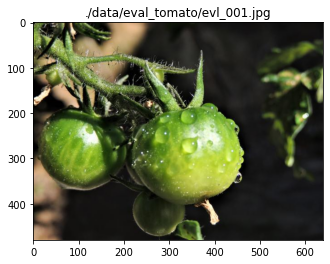

/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


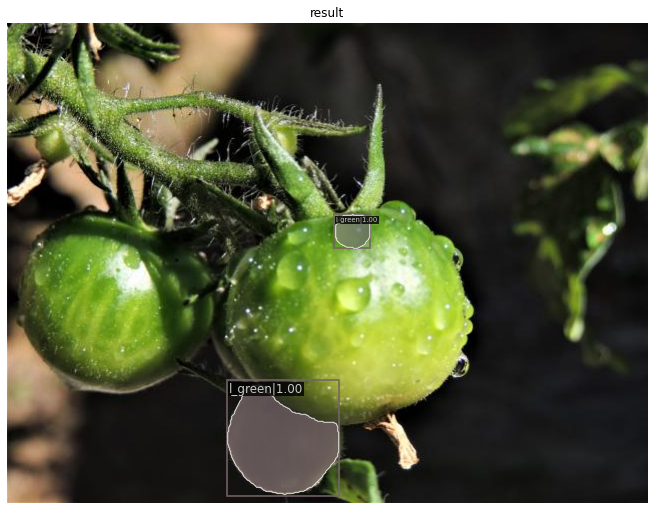

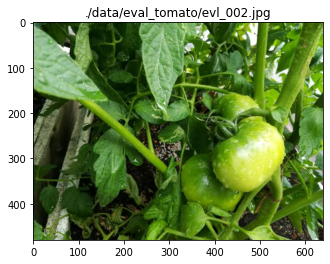

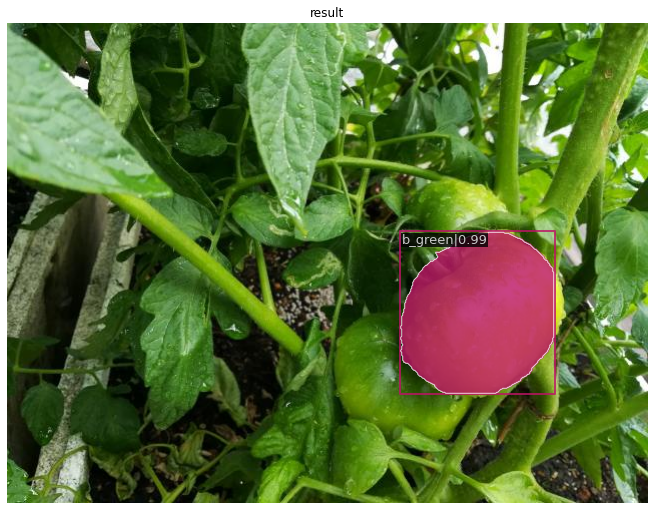

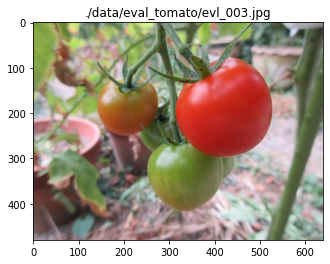

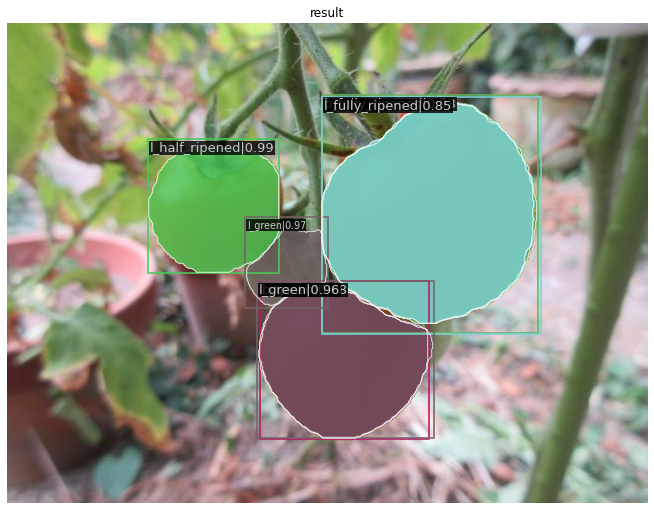

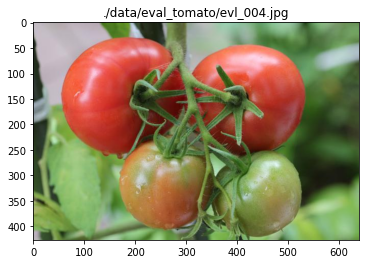

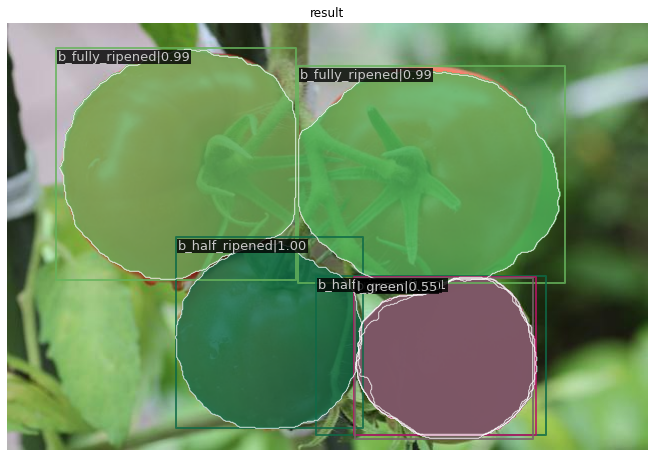

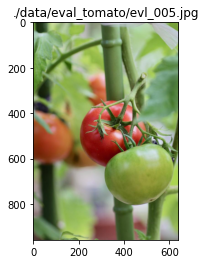

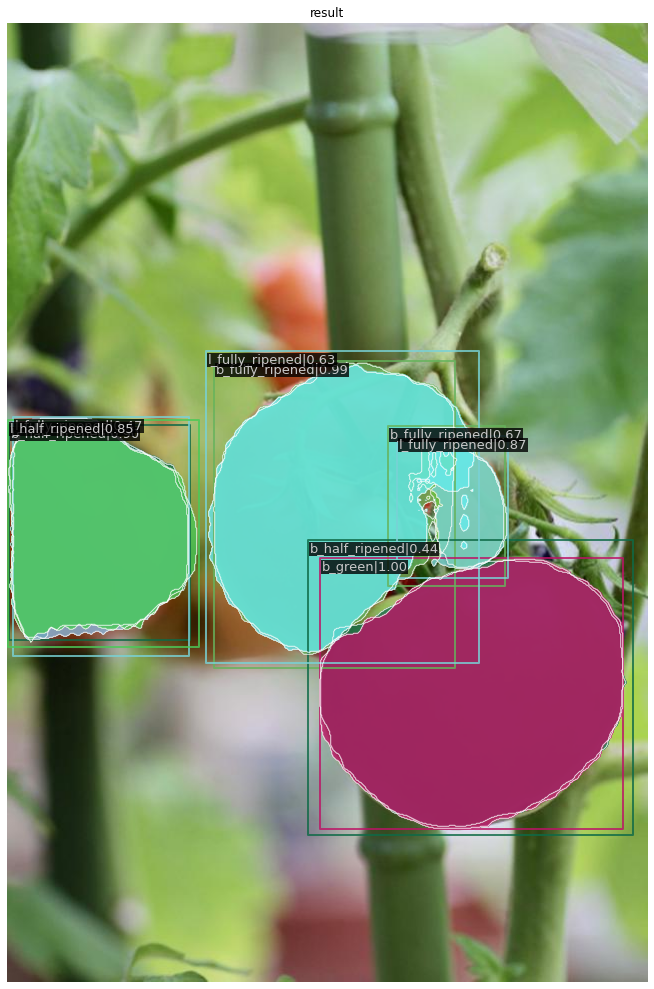

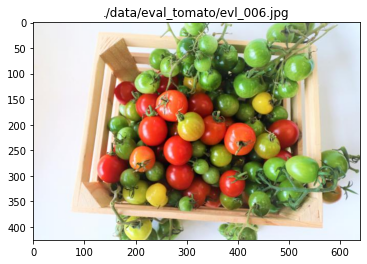

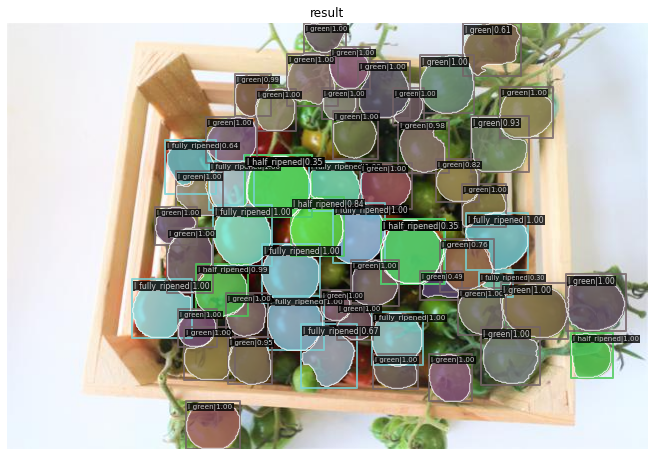

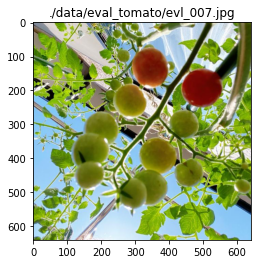

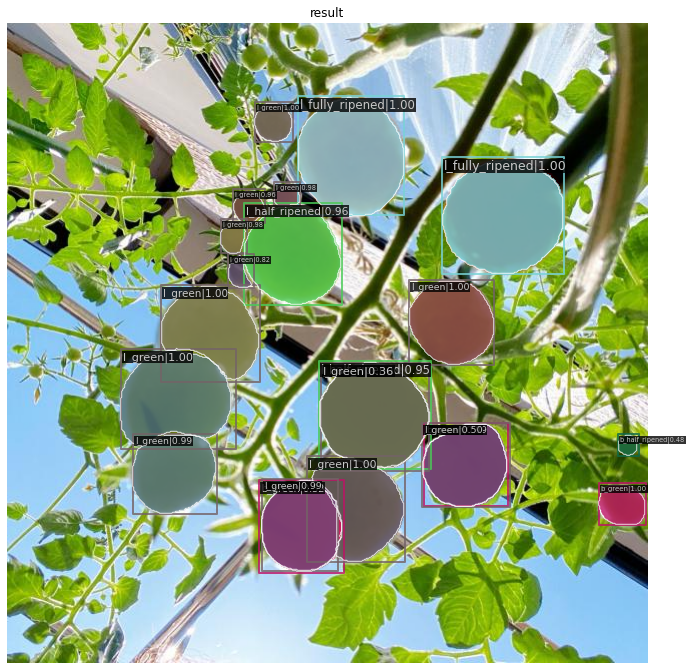

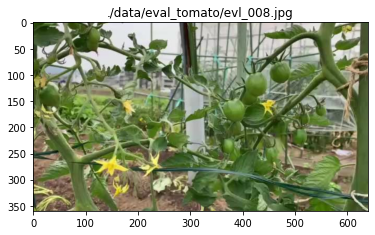

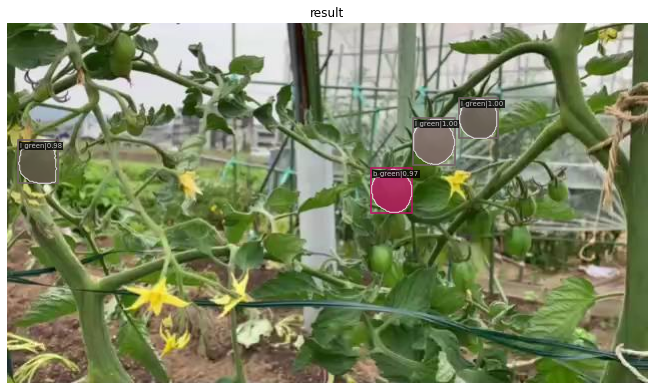

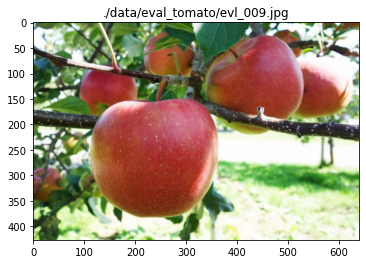

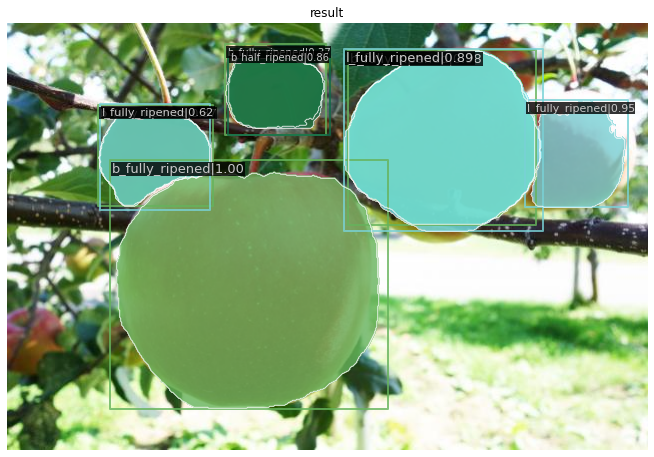

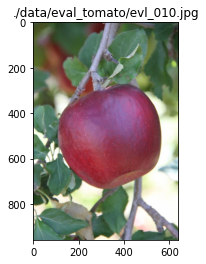

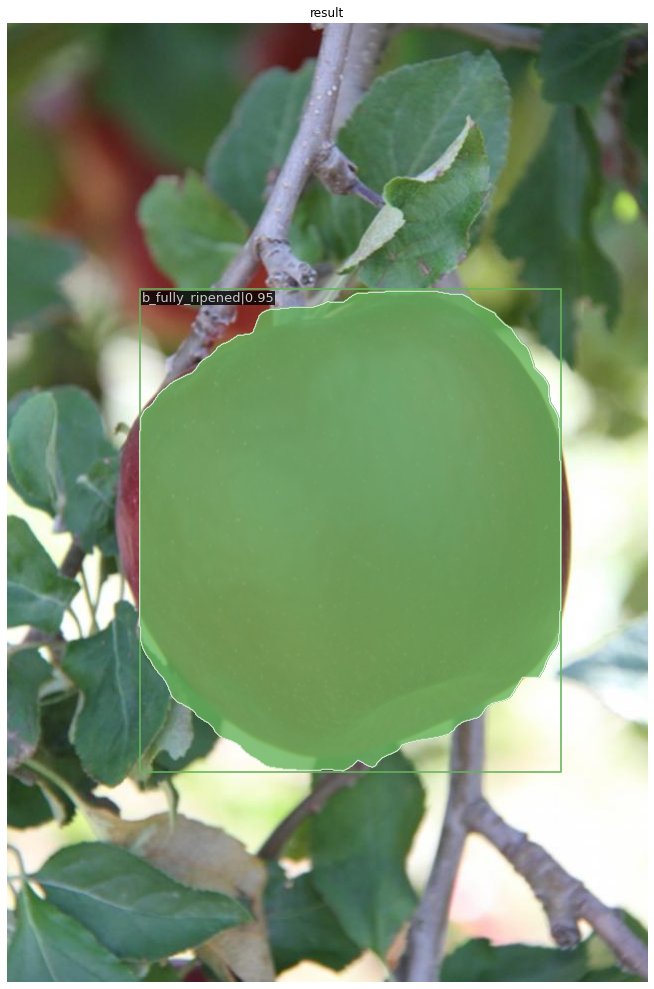

In [14]:
# 事前学習済みDetectorによる推定結果の評価
import mmcv
import matplotlib.pyplot as plt
import os
import glob
import pickle

!mkdir -p './data/eval_result/'
dst = './data/eval_result/'
src_imgs = sorted(glob.glob('./data/eval_tomato/*.jpg')) # オリジナル画像のパスと拡張子を設定

results = []

for i, f in enumerate(src_imgs):
    img = mmcv.imread(f) 
    # plt.figure(figsize=(10, 10))
    plt.title(str(f))
    plt.imshow(mmcv.bgr2rgb(img))
    plt.show()

    # 検出器での物体検出推定demo実行
    # # Use the detector to do inference
    result = inference_detector(model, img)
    # Let's plot the result
    show_result_pyplot(model, img, result, score_thr=0.3)
    # save result data
    results.append(result)

# 推定・mask結果ファイルをpickle形式で保存
with open(dst+'results.bin', 'wb') as p:
    pickle.dump(dst+'results.bin', p)

## 4.2 動画のセグメンテーション

In [ ]:
# 動画のセグメンテーション
# 動画データのロード 
!cd '/content/mmdetection'

# laboro_tomato datasetを./data/にシンボリックリンク
!mkdir -p ./data
!cp -Ri '/content/drive/MyDrive/Colab Notebooks/product_develop/video_tomato' './data'


In [18]:
# 動画セグメンテーション実行
src_movs = sorted(glob.glob('./data/video_tomato/*.mp4')) # オリジナル画像のパスと拡張子を設定

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  

#!mkdir -p './data/video_tomato/'
#dst = './data/video_tomato' # リサイズ画像の保存フォルダ
#!ln -s '/content/drive/MyDrive/Colab Notebooks/product_develop/video_tomato' './data'

!python "./demo/video_demo.py" "./data/video_tomato/tomato3.mp4"\
        "./configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py"\
        "./checkpoints/laboro_tomato_48ep.pth"\
        --out "./data/eval_result/tomato3.mp4"

load checkpoint from local path: ./checkpoints/laboro_tomato_48ep.pth
[                                                  ] 0/1752, elapsed: 0s, ETA:/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
[>>] 1752/1752, 5.3 task/s, elapsed: 333s, ETA:     0s
